In [1]:
# 1. Test the metric by Michel (anti Darmois Metric, aDM);
#    1a) Is it 0 for scalars?
#    1b) Is it >=0 otherwise?
#    1c) Is it =0 for conformal mappings, see: 
#        https://pypi.org/project/confmap/?
#    1d) Test on the closed form Darmois: 
#        Does the metric attain a higher value for f than for inv_darmois --- i.e.  aDM(inv_darmois)>aDM(f) typically?

# 2. It might be that high dimensionality is required to see that, typically, aDM(inv_darmois)>aDM(f) 
#    --- with f being the true mixing and inv_darmois the inverse of the Darmois construction:
#    In that case, in order to numerically check it, we need a differentiable implementation of the Darmois construction in D>2.
#    a) Consider whether it can be extended to D>2? 
#    b) Or whether it makes sense to solve the problem with the differentiable Darmois?

In [2]:
import jax
from jax import numpy as np
from jax import vmap
from jax import jacfwd

from jax import random
key = random.PRNGKey(42)

import numpy as onp

from metrics import aDM

Testing the anti-Darmois metric,

`insert formula`.

We generate the sources and keep them fixed throughout our simulations.

In [3]:
# N:=Number of samples
N = 6000
# D:=Number of dimensions
D = 2

# Generate the samples
S = random.uniform(key, shape=(N, D), minval=0.0, maxval=1.0)

**1a)** Is the metric equal to zero for scalar mixings?

In [4]:
from jax.scipy import special

def f_scalar(x):
    '''
    An arbitrary scalar nonlinear transformation
    
    Input: x: a 2d random variable
    
    Output: a 2d random variable. 
    1st component = x[0]**3
    2nd component = special.erfinv(x[1]*2.0-1.0)
    '''
    return np.array([x[0]**3, special.erfinv(x[1]*2.0-1.0)])

Jf_scalar = jacfwd(f_scalar)
Jf_scalar_batched = vmap(Jf_scalar)

aDM(Jf_scalar_batched, S)

DeviceArray(0., dtype=float32)

Apparently so.

**1b)** Is the metric >0 otherwise?

Hard to check in general, let's see for the three mixing from Aapo's paper.

In [5]:
from mixing_functions import f_1, f_2, f_3

In [6]:
Jf_1, Jf_2, Jf_3 = jacfwd(f_1), jacfwd(f_2), jacfwd(f_3)
Jf_1_batched, Jf_2_batched, Jf_3_batched = vmap(Jf_1), vmap(Jf_2), vmap(Jf_3)

In [7]:
aDM(Jf_1_batched, S)

DeviceArray(0.09358136, dtype=float32)

In [8]:
aDM(Jf_2_batched, S)

DeviceArray(0.7167423, dtype=float32)

In [9]:
aDM(Jf_3_batched, S)

DeviceArray(1.0244665, dtype=float32)

Apparently so.

It also look like the more nonlinear the function, the higher the value of **aDM**.

**1c)** Is the metric =0 for conformal mappings?

In [10]:
# How can I generate a random conformal mapping? See link below?
# https://pypi.org/project/confmap/

**1d)** Test it on the closed form Darmois.

For now limited to 2d.

In [11]:
# True mixing
from mixing_functions import f_g_unl

# Darmois construction
from mixing_functions import darmois_linear_gaussian

from scipy.stats import ortho_group

reps = 3*10**2

# Accumulate metric values for histogram
true_aDM_s = onp.zeros(reps)
inv_darmois_aDM_s = onp.zeros(reps)


# How many times do we "spot" the Darmois construction?
positive = 0

for i in range(reps):
    
    # Generate mixing
    A = random.multivariate_normal(key, mean=np.zeros(D*2), cov=np.eye(D*2)).reshape(2,2)
#     A = ortho_group.rvs(dim=2)
    
    f_unl, _ = f_g_unl(A)
    f_unl_batched = vmap(f_unl)
    
    X = f_unl_batched(S)
    
    # Compute the batched Jacobian
    Jf_unl = jacfwd(f_unl)
    Jf_unl_batched = vmap(Jf_unl)
    # Compute aDM true
    true_aDM = aDM(Jf_unl_batched, S)

    # Build Darmois
    darmois_single, inv_darmois_single = darmois_linear_gaussian(A)
    darmois, inv_darmois = vmap(darmois_single), vmap(inv_darmois_single)

    # Sources w. Darmois construction
    Y = darmois(X)

    # Compute the batched Jacobian
    Jinv_darmois = jacfwd(inv_darmois_single)
    Jinv_darmois_batched = vmap(Jinv_darmois)
    # Compute aDM for inv Darmois
    inv_darmois_aDM = aDM(Jinv_darmois_batched, Y)
    
    # Update random key
    key+=1
    
    true_aDM_s[i] = true_aDM
    inv_darmois_aDM_s[i] = inv_darmois_aDM
    
    if true_aDM < inv_darmois_aDM:
        positive+=1
        
print(positive/reps)

0.3566666666666667


7.504423
2.6588364


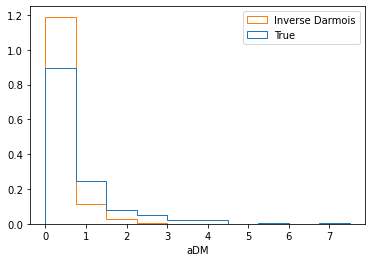

In [12]:
import matplotlib.pyplot as plt

from plotting import plot_histograms

plot_histograms([true_aDM_s, inv_darmois_aDM_s],
               ['True', 'Inverse Darmois'],
               'aDM')

print(np.max(true_aDM_s))
print(np.max(inv_darmois_aDM_s))

**1d)** **Is the metric invariant to scalar reparametrisation?**
And how does it change as $D$ grows?

Maybe try to replicate the above for different dimensions and see whether it drops as $D$ grows?

(Only for the true mixing for now; we at the moment don't have the closed form Darmois for $D>2$).

In [18]:
# N:=Number of samples
N = 6000
# D:=Number of dimensions
Dims = [2, 10, 20, 40, 50]

In [14]:
# True mixing
from mixing_functions import f_g_unl, f_lin

# Darmois construction
from mixing_functions import darmois_linear_gaussian

from scipy.stats import ortho_group

reps = 3*10**2

# Accumulate metric values for histograms
true_aDM_s_lin = onp.zeros((reps, len(Dims)))
true_aDM_s_unl = onp.zeros((reps, len(Dims)))

In [15]:
# How many times do we "spot" the Darmois construction?
# positive = onp.zeros(len(Dims))

for idx, Dim in enumerate(Dims):
    # Generate the samples
    S = random.uniform(key, shape=(N, Dim), minval=0.0, maxval=1.0)
    S_normal = special.erfinv(S*2.0-1.0)
    for i in range(reps):

        # Generate mixing
        A = random.multivariate_normal(key, mean=np.zeros(Dim*Dim), cov=np.eye(Dim*Dim)).reshape(Dim,Dim)
#         A = ortho_group.rvs(dim=Dim)

        # Linear mixing      
        f, _ = f_lin(A)
        f_batched = vmap(f)

        # Compute the batched Jacobian
        Jf = jacfwd(f)
        Jf_batched = vmap(Jf)
        # Compute aDM
        # NOTE THAT THIS HAS TO BE APPLIED TO S_normal
        true_aDM_lin = aDM(Jf_batched, S_normal)


        # Nonlinear mixing (uniform to normal then linearly mixed)
        f, _ = f_g_unl(A)
        f_batched = vmap(f)
    
        # Compute the batched Jacobian
        Jf = jacfwd(f)
        Jf_batched = vmap(Jf)
        # Compute aDM
        # NOTE THAT THIS HAS TO BE APPLIED TO THE UNIFORM R.V.'s S
        true_aDM_unl = aDM(Jf_batched, S)
        
        # Update random key
        key+=1

        true_aDM_s_lin[i, idx] = true_aDM_lin
        true_aDM_s_unl[i, idx] = true_aDM_unl
        
    print("Dimension =", Dim)

Dimension = 2
Dimension = 10
Dimension = 20
Dimension = 40
Dimension = 50


32.60223


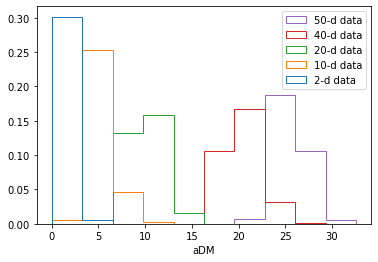

In [16]:
hist_values = [true_aDM_s_lin[:, i] for i in range(len(Dims))]
labels = [str(a)+"-d data" for a in Dims]

plot_histograms(hist_values,
               labels,
               'aDM')

print(np.max(true_aDM_s_lin))

32.602352


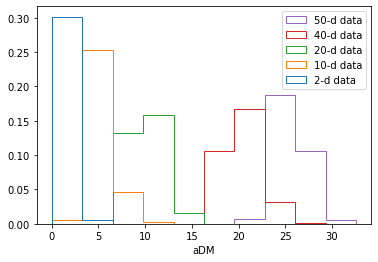

In [17]:
hist_values = [true_aDM_s_unl[:, i] for i in range(len(Dims))]
labels = [str(a)+"-d data" for a in Dims]

plot_histograms(hist_values,
               labels,
               'aDM')


print(np.max(true_aDM_s_unl))

The metric appears to be invariant to scalar reparametrization of the random variables, and it appears to grow as the dimensionality of the sources grows.